---
title: Genome assembly with long and short reads
authors:
      name: Samuele Greco
      email: samuele.greco@units.it
bibliography:
    - /home/jovyan/work/Esercitazioni/bib.bib
---

# Preparing the environment

We are going to use several bioinformatic tools to achieve our goal that need to be installed in this virtual environment. We will use `pip` and `mamba` to install all dependencies. We'll also download the databases required for our workflow. This cell will also create an extra environment to run some software with troublesome dependencies.

In [27]:
%%bash
mamba install -y -q -c bioconda fastp filtlong fastqc bwa-mem2 polypolish gridss bandage minimap2 staramr miniasm multiqc && echo "base install done"

install_software() {
    echo "Installing software in the extra_env environment..."
    mamba install -y -q -n extra_env -c bioconda unicycler quast nanoplot flye minipolish
}

# Check if the conda environment exists
if conda env list | grep -q extra_env; then
    echo "Conda environment extra_env exists."
    install_software
else
    echo "Conda environment extra_env does not exist. Creating it now..."
    mamba create -y -q -n extra_env -c bioconda unicycler quast nanoplot flye minipolish && echo "extra_env install done"
fi

if conda env list | grep -q busco; then
    echo "Conda environment busco exists."
else
    echo "Conda environment busco does not exist. Creating it now..."
    mamba create -y -q -n busco -c bioconda busco && echo "busco install done"
fi

if conda env list | grep -q prokka; then
    echo "Conda environment prokka exists."
else
    echo "Conda environment prokka does not exist. Creating it now..."
    mamba create -y -q -n prokka -c bioconda prokka && echo "prokka install done"
fi


base install done
Conda environment extra_env exists.
Installing software in the extra_env environment...
Conda environment extra_env does not exist. Creating it now...
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done
busco install done


# Let's assemble the genome of a *S. aureus* AMR strain 

this part of the hands-on is based on the galaxy training [Genome Assembly of MRSA from Oxford Nanopore MinION data (and optionally Illumina data)](https://training.galaxyproject.org/training-material/topics/assembly/tutorials/mrsa-nanopore/tutorial.html).

The datasets we explore today were generated with **Illumina** and **Nanopore** sequencing technologies and is an extract from [Hikichi *et al.*,2019](10.1128/mra.01212-19). 

## Illumina sequencing 

Illumina sequencing is a widely-used technology in genomics that allows researchers to read the DNA sequence of organisms with high accuracy and throughput. The process involves several key steps:

1. **Library Preparation**: DNA is fragmented into smaller pieces, and adapters are added to both ends of each fragment. These adapters are necessary for binding the DNA to a flow cell, a glass slide where the sequencing takes place.

2. **Cluster Generation**: The prepared DNA library is loaded onto the flow cell, where each fragment binds to complementary adapter sequences. Through a process called "bridge amplification," each DNA fragment is amplified to form clusters of identical DNA strands.

3. **Sequencing by Synthesis (SBS)**: During sequencing, four types of nucleotides (A, T, C, G) are introduced, each labeled with a different fluorescent dye. As the DNA polymerase incorporates nucleotides into the growing DNA strand, the fluorescent signal emitted is captured by a camera. This process is repeated, and the sequence of each cluster is determined base by base.

4. **Data Analysis**: The captured fluorescent signals are converted into sequences of DNA bases using bioinformatics software. This data can then be analyzed to identify genetic variations, mutations, and other genomic features.

### Advantages

- **High Throughput**: Illumina sequencing can generate massive amounts of data in a single run, making it suitable for large-scale projects such as whole-genome sequencing and metagenomics studies.
- **Accuracy**: The technology provides highly accurate sequencing data, which is crucial for applications like variant detection and clinical diagnostics.
- **Cost-Effective**: Over the years, the cost per base of sequencing has dramatically decreased, making it accessible for many research projects.
- **Versatility**: Illumina platforms can be used for a wide range of applications, including whole-genome sequencing, targeted sequencing, RNA sequencing, and epigenetic studies.

### Disadvantages

- **Short Read Lengths**: Illumina sequencing typically produces shorter reads compared to other technologies like Pacific Biosciences (PacBio) or Oxford Nanopore. Short read lengths can complicate the assembly of highly repetitive or complex genomic regions because these regions require longer sequences to accurately map and assemble. Short reads may not span entire repetitive elements or large structural variations, leading to gaps or errors in the assembled genome. Longer reads from other technologies can bridge these repetitive or complex regions, providing more accurate and contiguous assemblies.

## Nanopore sequencing

Nanopore sequencing is a cutting-edge technology in genomics that allows researchers to read DNA sequences by threading DNA molecules through engineered proteic pores on a membrane and measuring changes in electrical current between the two sides of the membrane.

### Process Overview

1. **Library Preparation**: DNA or RNA is fragmented and adapters are added to the ends. This prepares the nucleic acids for loading onto the nanopore device.

2. **Nanopore Sequencing**: The prepared DNA is introduced to a membrane containing nanopores. As individual DNA molecules pass through the nanopore, they cause disruptions in the electrical current. These disruptions are unique to each nucleotide or small string of nucleotides.

3. **Signal Detection and Base Calling**: The changes in electrical current are detected and recorded. Specialized software then translates these signals into a sequence of nucleotides, effectively reading the DNA sequence in real time.

4. **Data Analysis**: The generated sequences are analyzed to identify genetic variations, mutations, and other genomic features. This analysis can be done using various bioinformatics tools.

### Advantages

- **Long Read Lengths**: Nanopore sequencing can produce very long reads, often tens of kilobases or more. This makes it excellent for assembling complex genomes, detecting structural variants, and sequencing repetitive regions.
- **Real-Time Sequencing**: The technology allows for real-time data generation, which is beneficial for rapid diagnostics and monitoring experiments as they progress.
- **Minimal Sample Preparation**: The library preparation process for nanopore sequencing is relatively simple and quick compared to other sequencing methods.
- **Portability**: Some Nanopore devices, like the Oxford Nanopore MinION, are compact and portable, enabling field-based sequencing and on-site diagnostics.

### Disadvantages

- **Lower Accuracy**: Nanopore sequencing generally has a higher error rate compared to technologies like Illumina. However, accuracy has been improving with advancements in base-calling algorithms and chemistry.
- **Data Analysis Challenges**: The long and complex data generated by nanopore sequencing can be computationally intensive to analyze, requiring robust bioinformatics pipelines and substantial computational resources.
- **Throughput**: While improving, the throughput of nanopore sequencing is generally lower than that of high-throughput platforms like Illumina, making it less suitable for projects requiring massive amounts of data quickly.


## Goal of this hands-on

Our goal is to build an assembly of the genome of a Methicilin-resistant *Staphylococcus aureus* (MRSA) which was isolated from patients in Japan. After the assembly, we will evaluate and annotate the genome, finally looking for Anti-Microbial Resistance (AMR) genes. 


## Retrieving the sequencing reads
We use a reduced dataset that is conveniently stored in the zenodo data repository

In [14]:
%%bash
# Download the long reads
wget -q https://zenodo.org/record/10669812/files/DRR187567.fastq.bz2 && bzcat DRR187567.fastq.bz2 > long_reads.fastq
# Download the paired end short reads
wget -q https://zenodo.org/record/10669812/files/DRR187559_1.fastqsanger.bz2 && bzcat DRR187559_1.fastqsanger.bz2 > illumina_1.fastq
wget -q https://zenodo.org/record/10669812/files/DRR187559_2.fastqsanger.bz2 && bzcat DRR187559_2.fastqsanger.bz2 > illumina_2.fastq

## Quality control of raw reads and trimming

Now that we have the raw sequencing reads we need to check their quality. We will take this chance to also compare the results of the two sequencing technologies. Run the following cell to run fastQC on all files.

:::{note} command line description
:class: dropdown

```bash
fastqc -t 3 *.fastq 2> fastqc.log && multiqc .
```

- **`fastqc`**: Execute the FastQC tool, which is used for quality control checks on raw sequence data.

- **`-t 3`**:
  - **`-t`**: Number of threads to use (here, 3 threads).

- **`*.fastq`**:
  - Process all FASTQ files in the current directory (the `*` is a wildcard that matches all files with the `.fastq` extension).

- **`2> fastqc.log`**:
  - Redirect standard error (stderr) output to `fastqc.log` file (useful for logging errors and progress).

- **`&& multiqc .`**:
  - **`&&`**: Logical AND operator that ensures the following command (`multiqc .`) runs only if the preceding command (`fastqc -t 3 *.fastq 2> fastqc.log`) succeeds.
  - **`multiqc .`**: Execute the MultiQC tool in the current directory (`.`) to aggregate results from FastQC and generate a combined report.

:::

In [4]:
%%bash
fastqc -t 3 *.fastq 2> fastqc.log && multiqc .

null
null
null
Analysis complete for illumina_1.fastq
Analysis complete for illumina_2.fastq
Analysis complete for long_reads.fastq



  /// ]8;id=448620;https://multiqc.info\MultiQC]8;;\ 🔍 | v1.21

|           multiqc | MultiQC Version v1.22 now available!
|           multiqc | Search path : /home/jovyan/work/Esercitazioni
|         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 24/24   ./Esercitazione4.ipynb
|            fastqc | Found 3 reports
|           multiqc | Report      : multiqc_report.html
|           multiqc | Data        : multiqc_data
|           multiqc | MultiQC complete


After updating the left side column of this interface and clicking on the folder icon you will notice that some new files appeared with `fastqc` in their filename. You can double click the `.html` files to check the results. The `multiqc_report.html` file will provide a unified overview of the main results of the three separate `fastqc` runs. If you get an error about javascript being disabled click on the `trust html` button at the top left of the page.  
We can now proceed to trim the short reads with `fastp`. 

:::{note} command line description
:class: dropdown

- **`fastp`**: Execute the `fastp` tool, which is used for fast all-in-one preprocessing of FASTQ files.

- **`-i illumina_1.fastq`**:
  - **`-i`**: Input file for the first pair of Illumina reads (here, `illumina_1.fastq`).

- **`-I illumina_2.fastq`**:
  - **`-I`**: Input file for the second pair of Illumina reads (here, `illumina_2.fastq`).

- **`-f 15`**:
  - **`-f`**: Trim the first 15 bases from the 5' end of the first read.

- **`-F 15`**:
  - **`-F`**: Trim the first 15 bases from the 5' end of the second read.

- **`-t 2`**:
  - **`-t`**: Trim the last 2 bases from the 3' end of the first read.

- **`-T 2`**:
  - **`-T`**: Trim the last 2 bases from the 3' end of the second read.

- **`-w 4`**:
  - **`-w`**: Number of threads to use (here, 4 threads).

- **`-o illumina_1.trimmed.fastq`**:
  - **`-o`**: Output file for the trimmed first read (here, `illumina_1.trimmed.fastq`).

- **`-O illumina_2.trimmed.fastq`**:
  - **`-O`**: Output file for the trimmed second read (here, `illumina_2.trimmed.fastq`).

:::


In [6]:
%%bash
fastp -i illumina_1.fastq -I illumina_2.fastq -f 15 -F 15 -t 2 -T 2 -w 4 -o illumina_1.trimmed.fastq -O illumina_2.trimmed.fastq 

Read1 before filtering:
total reads: 451782
total bases: 86220364
Q20 bases: 80724740(93.6261%)
Q30 bases: 70151017(81.3625%)

Read2 before filtering:
total reads: 451782
total bases: 100061490
Q20 bases: 95987612(95.9286%)
Q30 bases: 86575653(86.5225%)

Read1 after filtering:
total reads: 451781
total bases: 78515916
Q20 bases: 73444855(93.5414%)
Q30 bases: 63460500(80.825%)

Read2 after filtering:
total reads: 451781
total bases: 91340684
Q20 bases: 87701366(96.0157%)
Q30 bases: 78880636(86.3587%)

Filtering result:
reads passed filter: 903562
reads failed due to low quality: 2
reads failed due to too many N: 0
reads failed due to too short: 0
reads with adapter trimmed: 177396
bases trimmed due to adapters: 1064541

Duplication rate: 0.0154942%

Insert size peak (evaluated by paired-end reads): 313

JSON report: fastp.json
HTML report: fastp.html

fastp -i illumina_1.fastq -I illumina_2.fastq -f 15 -F 15 -t 2 -T 2 -w 4 -o illumina_1.trimmed.fastq -O illumina_2.trimmed.fastq 
fastp v

let's use some python to view the changes in quality and composition of reads before and after trimming 

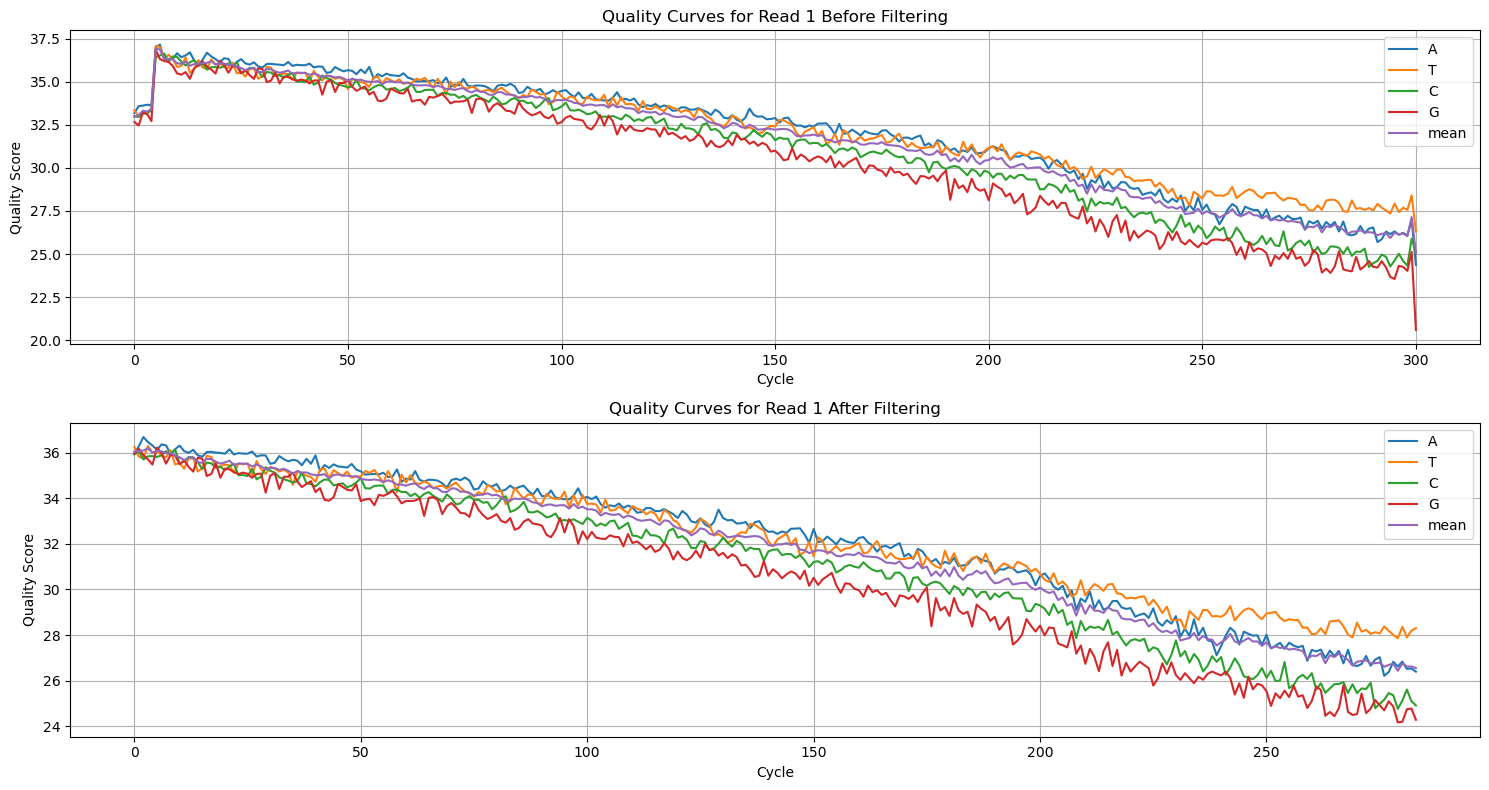

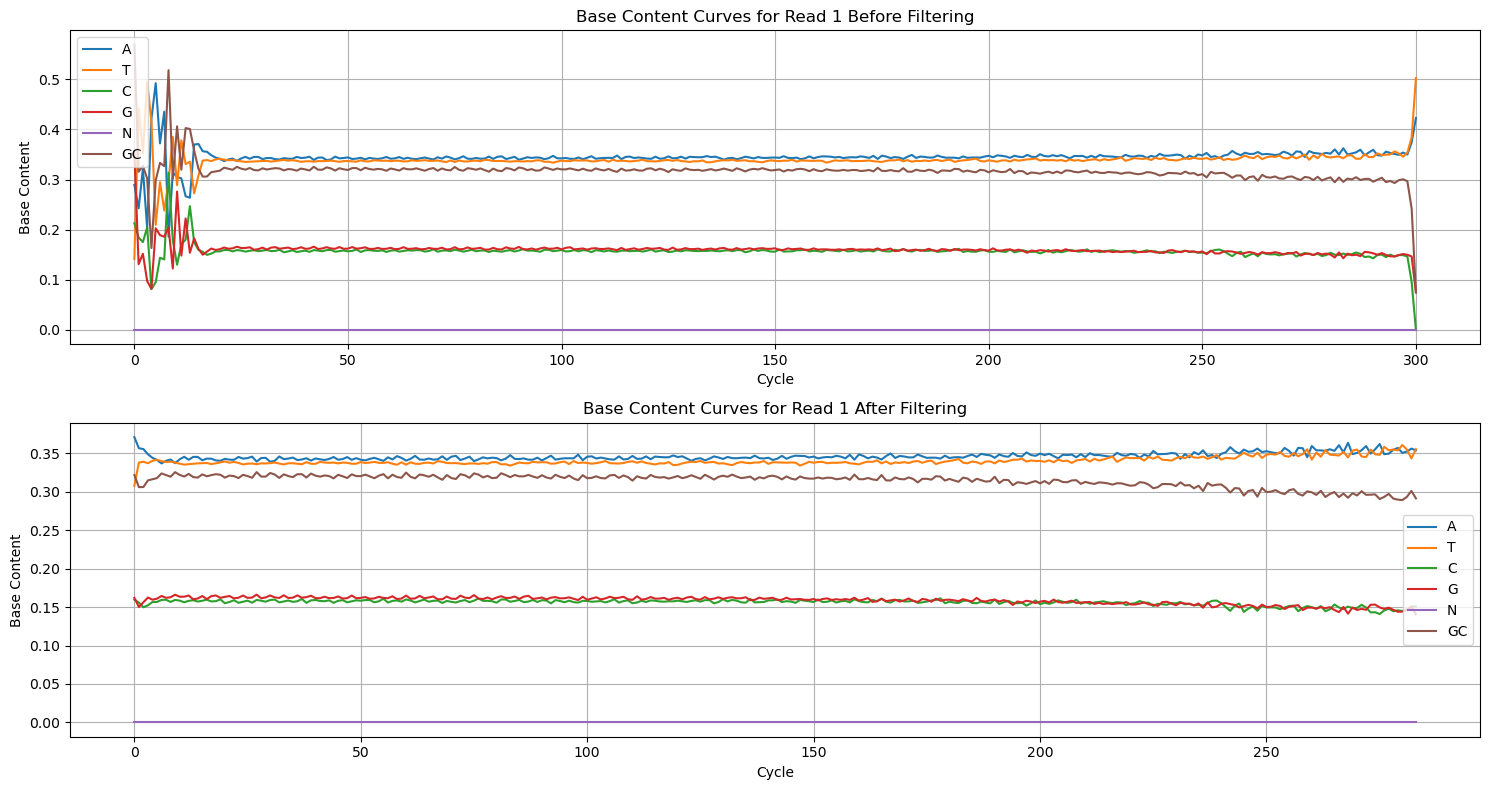

In [14]:
import json
import matplotlib.pyplot as plt

# Load the JSON data
with open('fastp.json') as f:
    data = json.load(f)

# Extract quality curves and base content curves before and after filtering
quality_curves_before = data['read1_before_filtering']['quality_curves']
quality_curves_after = data['read1_after_filtering']['quality_curves']

content_curves_before = data['read1_before_filtering']['content_curves']
content_curves_after = data['read1_after_filtering']['content_curves']

# Plot quality curves before and after filtering
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Quality Curves - Before Filtering
axes[0].set_title('Quality Curves for Read 1 Before Filtering')
for base, curve in quality_curves_before.items():
    axes[0].plot(curve, label=base)
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('Quality Score')
axes[0].legend()
axes[0].grid(True)

# Quality Curves - After Filtering
axes[1].set_title('Quality Curves for Read 1 After Filtering')
for base, curve in quality_curves_after.items():
    axes[1].plot(curve, label=base)
axes[1].set_xlabel('Cycle')
axes[1].set_ylabel('Quality Score')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Plot base content curves before and after filtering
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Base Content Curves - Before Filtering
axes[0].set_title('Base Content Curves for Read 1 Before Filtering')
for base, curve in content_curves_before.items():
    axes[0].plot(curve, label=base)
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('Base Content')
axes[0].legend()
axes[0].grid(True)

# Base Content Curves - After Filtering
axes[1].set_title('Base Content Curves for Read 1 After Filtering')
for base, curve in content_curves_after.items():
    axes[1].plot(curve, label=base)
axes[1].set_xlabel('Cycle')
axes[1].set_ylabel('Base Content')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


We can now filter the long reads as well, based on a size threshold and using the short high-quality illumina reads (given that they guarantee complete coverage) as a reference. In this case, Filtlong ignores the Phred quality scores and instead judges read quality using [*k-mer*](https://en.wikipedia.org/wiki/K-mer) matches to the reference (a more accurate gauge of quality).

:::{note}command line description
:class: dropdown

- **`!mamba run`**: Execute a command within a conda environment using Mamba.
  - **`-n extra_env`**: Specify the conda environment named `extra_env`.

- **`filtlong`**: Execute the Filtlong tool, which filters long reads.

- **`--min_length 1000`**:
  - **`--min_length`**: Minimum read length to keep (here, 1000 bases).

- **`-1 illumina_1.trimmed.fastq`**:
  - **`-1`**: First pair of Illumina reads (here, `illumina_1.trimmed.fastq`).

- **`-2 illumina_2.trimmed.fastq`**:
  - **`-2`**: Second pair of Illumina reads (here, `illumina_2.trimmed.fastq`).

- **`long_reads.fastq`**: Input file containing long reads.

- **`> long_reads.filtered.fastq`**:
  - **`>`**: Redirect output to a file.
  - **`long_reads.filtered.fastq`**: Output file for filtered long reads.

:::


In [18]:
!mamba run -n extra_env filtlong --min_length 1000 -1 illumina_1.trimmed.fastq -2 illumina_2.trimmed.fastq long_reads.fastq > long_reads.filtered.fastq


Hashing 16-mers from Illumina reads
  illumina_1.trimmed.fastq (78,515,916 bp)
  illumina_2.trimmed.fastq (91,340,684 bp)
  903,562 reads, 5,863,028 16-mers

Scoring long reads
  91,288 reads (621,945,741 bp)

Outputting passed long reads




## Assembly of long reads

After this step is done we can assemble our draft genome using the long reads. For this first assembly we will use flye. 
In this case the assembly would take about 45 minutes, therefore the output is already provided in the directory `flye_dir` in the same page of this workbook. For reference, the following is the command that generated the assembly.
```bash
!mamba run -n extra_env flye --nano-corr long_reads.filtered.fasta -t 4 -o flye_Saureus 
```
:::{note}command description
:class: dropdown
- **`mamba run`**: Run a command within a conda environment.
  - **`-n extra_env`**: Specify the conda environment named `extra_env`.

- **`flye`**: Execute the Flye assembler.

- **`--nano-corr long_reads.filtered.fasta`**:
  - **`--nano-corr`**: Indicates input reads are pre-corrected Nanopore reads.
  - **`long_reads.filtered.fasta`**: Input file containing the filtered long reads.

- **`-t 4`**:
  - **`-t`**: Number of threads to use, in this system please use 4 or less to allow balanced load for all concurrent users.

- **`-o flye_Saureus`**:
  - **`-o`**: Specify the output directory (`flye_Saureus`).

:::

### Visualize the assembly graph

The output of this assembly is `gfa` file that represents the assembly graph. We can have a look at the assembly graph to judge the results of the raw assembly. This can be done with **Bandage** that usually offers also a nice graphical interface to explore assembly graphs. In this case we can use the command line to produce a png image of the assembly graph. 

```bash
Bandage image flye_Saureus/assembly_graph.gfa flye_Saureus/assembly_graph.png --width 800 --height 800
```

:::{figure}flye_Saureus/assembly_graph.png
The assembly graph generated by flye. Notice that the assembler was able to correctly circularize it and even build what appears to be a plasmid. 
:::

## Polishing the assembly with short reads

Polishing with short reads is a process used to improve the accuracy and quality of genome assemblies, particularly those generated from long-read sequencing technologies (like Oxford Nanopore in our case), which are prone to higher error rates. We can therefore use our high-quality short Illumina reads to perform this task using polypolish. The following command is composed of three steps:
1. Indexing the assembly
2. Mapping short reads to the assembly
3. Polishing the assembly with the mapping output

:::{note}command line description
:class: dropdown

1. **BWA-MEM2 Indexing**
   ```bash
   bwa-mem2 index flye_Saureus/assembly.fasta 2> polishing_indexing.log
   ```
   - **`bwa-mem2`**: An improved version of BWA-MEM, a tool for aligning sequence reads to a reference genome.
   - **`index`**: This command creates an index of the reference genome, which is necessary for alignment.
   - **`flye_Saureus/assembly.fasta`**: The reference genome file to be indexed (the assembled genome from Flye).
   - **`2> polishing_indexing.log`**: Redirects the standard error (stderr) output to `polishing_indexing.log` for logging purposes.

2. **BWA-MEM2 Mapping**
   ```bash
   bwa-mem2 mem -t 4 -o Saureus_polishing_map.sam flye_Saureus/assembly.fasta illumina_1.trimmed.fastq illumina_2.trimmed.fastq 2> polishing_mapping.log
   ```
   - **`bwa-mem2 mem`**: The command to perform sequence alignment using BWA-MEM2.
   - **`-t 4`**: Number of threads to use (here, 4 threads).
   - **`-o Saureus_polishing_map.sam`**: Specifies the output file for the alignments in SAM format.
   - **`flye_Saureus/assembly.fasta`**: The reference genome file.
   - **`illumina_1.trimmed.fastq`**: The first FASTQ file of paired-end Illumina reads.
   - **`illumina_2.trimmed.fastq`**: The second FASTQ file of paired-end Illumina reads.
   - **`2> polishing_mapping.log`**: Redirects the standard error (stderr) output to `polishing_mapping.log` for logging purposes.

3. **Polypolish Polishing**
   ```bash
   polypolish polish flye_Saureus/assembly.fasta Saureus_polishing_map.sam > Saureus_polished_assembly.fasta
   ```
   - **`polypolish`**: A tool used for polishing genome assemblies.
   - **`polish`**: The command to perform the polishing.
   - **`flye_Saureus/assembly.fasta`**: The reference genome file to be polished.
   - **`Saureus_polishing_map.sam`**: The SAM file containing the mapped reads.
   - **`>`**: Redirects the output to a file.
   - **`Saureus_polished_assembly.fasta`**: The output file containing the polished genome assembly.

:::

In [18]:
%%bash
bwa-mem2 index flye_Saureus/assembly.fasta 2> polishing_indexing.log
bwa-mem2 mem -t 4 -o Saureus_polishing_map.sam flye_Saureus/assembly.fasta illumina_1.trimmed.fastq illumina_2.trimmed.fastq 2> polishing_mapping.log
polypolish polish flye_Saureus/assembly.fasta Saureus_polishing_map.sam > Saureus_polished_assembly.fasta

ref_seq_len = 5934294
count = 0, 1990723, 2967147, 3943571, 5934294
BWT[3215714] = 4
CP_SHIFT = 6, CP_MASK = 63
sizeof CP_OCC = 64
max_occ_ind = 92723



Starting Polypolish polish (2024-05-17 10:14:16)
    Polypolish is a tool for polishing genome assemblies with short reads.
Unlike other tools in this category, Polypolish uses SAM files where each read
has been aligned to all possible locations (not just a single best location).
This allows it to repair errors in repeat regions that other alignment-based
polishers cannot fix.

Polypolish version: 0.6.0

Input assembly:
  flye_Saureus/assembly.fasta

Input short-read alignments:
  Saureus_polishing_map.sam

Settings:
  --fraction_invalid 0.2
  --fraction_valid 0.5
  --max_errors 10
  --min_depth 5
  not logging debugging information


Loading assembly (2024-05-17 10:14:16)
contig_1 (2,907,064 bp)
contig_2 (60,083 bp)


Loading alignments (2024-05-17 10:14:16)
Saureus_polishing_map.sam: 903,504 alignments from 451,770 reads

Filtering for high-quality end-to-end alignments:
  881,809 alignments kept
  21,695 alignments discarded


Polishing assembly sequences (2024-05-17 10:14:22)
    

From the output of polypolish we can see that indeed some changes were made to the final assembly produced by flye. Specifically, the assembled contigs got longer and a few positions were changed. Nanopore reads can have homopolymer deletions - a run of AAAA may be interpreted as AAA - so the more accurate illumina reads may correct these parts of the long-read assembly. In the changes file, there may be a lot of cases showing a supposed deletion (represented by a dot) being corrected to a base.

## Evaluating the assembly
There are several programs to evaluate a bacterial genome assembly, each based on different scoring systems. In this case we will only use **BUSCO** (Benchmarking Universal Single-Copy Orthologs) to assess the assembly completeness.  It works by identifying and quantifying the presence of universal single-copy orthologs, which are genes conserved across a wide range of species and typically present as single copies in a genome.

:::{note}command line description
:class: dropdown
1. **mamba run -n busco**:
   - **mamba**: A package manager for managing software environments and packages, similar to `conda` but designed to be faster.
   - **run**: Execute a command within a specific environment.
   - **-n busco**: Specifies the environment named `busco` in which to run the following command.

2. **busco**:
   - The main executable of the BUSCO tool.

3. **-i Saureus_polished_assembly.fasta**:
   - **-i**: Input file flag.
   - **Saureus_polished_assembly.fasta**: The input genome assembly file in FASTA format.

4. **-l bacteria**:
   - **-l**: Lineage dataset flag.
   - **bacteria**: Specifies that the bacterial lineage dataset should be used for benchmarking.

5. **-o Saureus_BUSCO**:
   - **-o**: Output directory flag.
   - **Saureus_BUSCO**: Specifies the name of the output directory where the results will be stored.

6. **-m geno**:
   - **-m**: Mode flag.
   - **geno**: Specifies the mode of analysis. In this case, `geno` indicates genome mode.

7. **-c 4**:
   - **-c**: Number of CPU cores flag.
   - **4**: Specifies that 4 CPU cores should be used for the analysis.

8. **-f**:
   - Force overwrite flag. Ensures that if the output directory already exists, it will be overwritten.

9. **> busco.log**:
   - Redirects the standard output (and possibly standard error) to a file named `busco.log`.

:::


In [43]:
!mamba run -n busco busco -i Saureus_polished_assembly.fasta -l bacteria -o Saureus_BUSCO -m geno -c 4 -f > busco.log

we can then visualize the results with some overcomplicated python code.

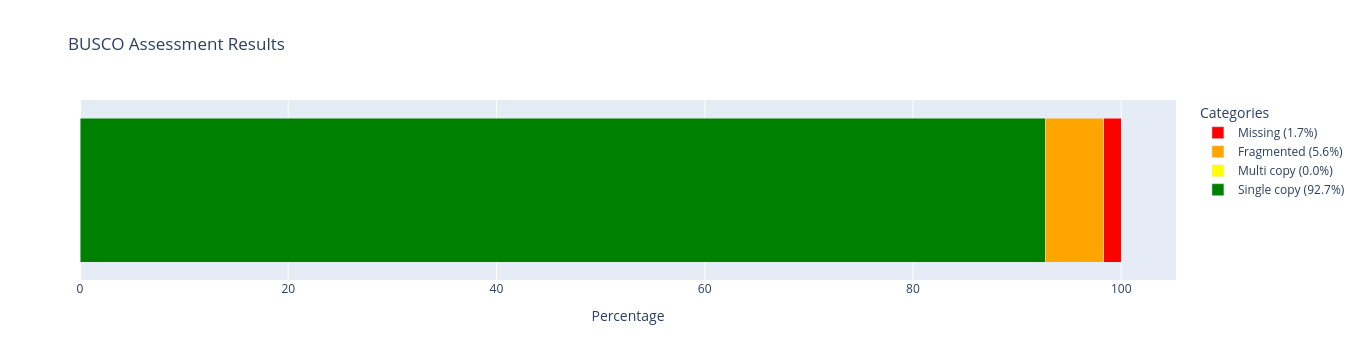

In [46]:
import json
import plotly.graph_objects as go

# Load the JSON data
with open('Saureus_BUSCO/short_summary.specific.bacteria_odb10.Saureus_BUSCO.json') as f:
    busco_data = json.load(f)

# Extract relevant data
results = busco_data['results']
categories = [ 'Single copy', 'Multi copy', 'Fragmented', 'Missing']
percentages = [
    results['Single copy percentage'],
    results['Multi copy percentage'],
    results['Fragmented percentage'],
    results['Missing percentage']
]
genes = [
    results['Single copy BUSCOs'],
    results['Multi copy BUSCOs'],
    results['Fragmented BUSCOs'],
    results['Missing BUSCOs']
]

# Create the stacked horizontal bar plot
fig = go.Figure()

# Add each category as a separate trace
for category, percentage, gene, color in zip(categories, percentages, genes, [ 'green', 'yellow', 'orange', 'red']):
    fig.add_trace(go.Bar(
        y=[''],
        x=[percentage],
        name=f'{category} ({percentage}%)',
        orientation='h',
        marker=dict(color=color),
        hovertemplate=f'{category}: {percentage}%<br>Genes: {gene}<extra></extra>'
    ))

# Update layout
fig.update_layout(
    barmode='stack',
    title='BUSCO Assessment Results',
    xaxis_title='Percentage',
    yaxis_title='',
    legend_title_text='Categories'
)

# Display the plot
fig.show()


As you can see the complete and single copy BUSCO score is above 90%, meaning that we find more than 90% of genes we expect to be present in single copy. Obviously the gene set used for testing is limited to a relatively small number of gene, so we do not know anything about genes that are not included in this set. 

## Annotation of the assembled genome 

Now that we have produced a fairly good assembly the next step is to locate the positions of the genes and assign them a functional annotation. For this task we will use **prokka**, a well established prokaryote genome annotation software, which will also provide functional annotation. 

:::{note} command line description
:class: dropdown

1. **`prokka`**: This is the actual program being executed.
2. **`Saureus_polished_assembly.fasta`**: This is the input file for Prokka, which contains the polished genome assembly in FASTA format.
3. **`--genus Staphylococcus`**: Specifies the genus of the organism for annotation.
4. **`--species aureus`**: Specifies the species of the organism for annotation.
5. **`--cpus 4`**: Allocates 4 CPU cores for the Prokka process to speed up the annotation.
6. **`--outdir Saureus_PROKKA`**: Specifies the output directory where the results will be stored.
7. **`--force`**: Forces Prokka to overwrite the output directory if it already exists.
8. **`> prokka.log`**: Redirects the standard output and error messages to a log file named `prokka.log` for later review.



:::


In [55]:
!mamba run -n prokka prokka Saureus_polished_assembly.fasta --genus Staphylococcus --species aureus --cpus 4 --outdir Saureus_PROKKA --force 2> prokka.log 

[tbl2asn-forever] Found Prokka input, correcting dates in .gbf|.sqn files.
[tbl2asn-forever] Correcting dates in Saureus_PROKKA/PROKKA_05172024.gbf
[tbl2asn-forever] Correcting dates in Saureus_PROKKA/PROKKA_05172024.sqn
[tbl2asn-forever] Dates changed from 01-JAN-2019 to 17-MAY-2024



If you want you can visualize the annotation on your computer by downloading and installing [JBrowse2](https://jbrowse.org/jb2/). If you do so, follow these steps for your first visualization:
1. download the `.gff` and `.fsa` files from the navigator on the left
2. open JBrowse2
3. click on **open sequence files(s)**
4. insert an assembly name
5. change Type to **FastaAdapter**
6. click on **choose file** and select the `.fsa` file
7. click on **submit**
8. select **Linear genome view**
9. click on **launch view**
10. click on **file > Open track**
11. select **file** and then **choose file** import the `.gff` file
12. click **Next**
13. select the assembly you imported earlier
14. click **add** and open the view in the main window

### Detection of AMR genes

The last step of this hands-on is to find and locate Antimicrobial resistance genes in the assembled genome. We can use **staramr** for this purpose. It will scan the genome against the **ResFinder**, **PointFinder** and **PlasmidFinder** databases (which first need to be obtained).  

:::{note} command line description
:class: dropdown

1. **Building the StarAMR Database**
   ```bash
   staramr db build --dir databases
   ```
   - **`staramr`**: This is a tool used to detect antimicrobial resistance genes in bacterial genomes.
   - **`db build`**: This command builds the StarAMR database, which is necessary for running the `staramr search` command.
   - **`--dir databases`**: Specifies the directory where the database should be built or stored. Here, the `databases` directory is used.

2. **Searching for Antimicrobial Resistance Genes**
   ```bash
   staramr search -d databases -n 4 -o Saureus_staramr Saureus_PROKKA/PROKKA_*.fsa
   ```
   - **`staramr search`**: This command searches for antimicrobial resistance genes in the provided sequence files.
   - **`-d databases`**: Specifies the directory where the StarAMR database is located. This should be the same directory that was specified during the database build step.
   - **`-n 4`**: Number of threads to use for the search (here, 4 threads).
   - **`-o Saureus_staramr`**: Specifies the output directory where the search results will be saved. Here, the `Saureus_staramr` directory is used.
   - **`Saureus_PROKKA/PROKKA_*.fsa`**: Specifies the input files for the search. The `PROKKA_*.fsa` is a wildcard pattern that matches all `.fsa` files produced by the PROKKA annotation tool within the `Saureus_PROKKA` directory.

:::

In [66]:
%%bash
staramr db build --dir databases
staramr search -d databases -n 4 -o Saureus_staramr Saureus_PROKKA/PROKKA_*.fsa

/opt/conda/lib/python3.11/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(
2024-05-17 14:24:29 INFO: Cloning resfinder db [https://bitbucket.org/genomicepidemiology/resfinder_db.git] to [databases/update/resfinder]
2024-05-17 14:24:43 INFO: Cloning pointfinder db [https://bitbucket.org/genomicepidemiology/pointfinder_db.git] to [databases/update/pointfinder]
2024-05-17 14:24:49 INFO: Cloning plasmidfinder db [https://bitbucket.org/genomicepidemiology/plasmidfinder_db.git] to [databases/update/plasmidfinder]
2024-05-17 14:24:52 WARNING: Built non-default ResFinder/PointFinder/PlasmidFinder database version

Now we can have a look at the results and also convert them to `gff3` with some python code and add this as a new track to the genome view in JBrowse2

In [80]:
import pandas as pd

# Read the staramr detailed summary file
input_file = "Saureus_staramr/detailed_summary.tsv"
output_file = "Saureus_AMR.gff3"

# Define function to convert row to GFF3 format
def row_to_gff3(row):
    row = row.fillna("")
    seqid = row['Contig']
    source = "staramr"
    type_ = "gene"
    start = row['Start']
    end = row['End']
    score = "."
    strand = "+" if start < end else "-"
    if start > end:
        temp = start
        start = end
        end = temp
    phase = "."
    attributes = f"ID={row['Data']};Name={row['Data']};Phenotype={row['CGE Predicted Phenotype']};"
    
    gff3_line = f"{seqid}\t{source}\t{type_}\t{start}\t{end}\t{score}\t{strand}\t{phase}\t{attributes}"
    return gff3_line

# Read the TSV file into a DataFrame
df = pd.read_csv(input_file, sep='\t')

# Open the GFF3 file for writing
with open(output_file, 'w') as gff3:
    # Write the GFF3 header
    gff3.write("##gff-version 3\n")
    
    # Write each row from the dataframe as a GFF3 line
    for index, row in df.iterrows():
        gff3_line = row_to_gff3(row)
        gff3.write(gff3_line + "\n")

print(f"Conversion complete. GFF3 file saved as {output_file}")


Conversion complete. GFF3 file saved as Saureus_AMR.gff3


# Hands-on: Assembly and annotation of the plastidial genome of *Ipomoea batatas*

Now it is your turn to try assembling a simple genome from a combination of long and short reads. You can have a look at the process we followed for *S. aureus* and adapt it to this case. The main differences here are that the short reads are from a single-end sequencing and the assembly of long reads will be feasible in a short time on this system using only 4 threads per user. Remeber that you can usually look at helps of the commands by adding the `-h` or `--help` flags or by looking up their manuals. For all issues you can always talk with your colleagues or ask me! 

You can retrieve the raw sequencing reads with the following command cell. Good luck!

In [82]:
%%bash
wget -q https://zenodo.org/record/3567224/files/sweet-potato-chloroplast-illumina-reduced.fastq
wget -q  https://zenodo.org/record/3567224/files/sweet-potato-chloroplast-nanopore-reduced.fastq
